<a href="https://colab.research.google.com/github/FilippoAiraldi/RL-demos/blob/main/k_armed_testbed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K armed bandit testbed 

Figure 2.2 and 2.3 and Exersice 2.5: from 'Reinforcement Learning: an introduction' by Sutton & Barto.

In [7]:
import numpy as np
from dataclasses import dataclass
from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm

## Simulation

In [8]:
@dataclass
class Simulation():
    qa: np.ndarray
    A: np.ndarray
    R: np.ndarray
    name: str = ''

greedy_policy = lambda qa, eps, K: qa.argmax() if np.random.rand() > eps else np.random.randint(K)
get_reward = lambda q, a: np.random.normal(loc = q[a])

def play_one_game(args):
    eps, K, tmax, qa, Qa, alpha, qa_type = args

    # initialize registers to zeros
    A = np.zeros(tmax, dtype = np.uint);
    R = np.zeros_like(A, dtype = np.float)

    # initialize current estimates of action values and action counters
    use_sampleavg = alpha == 'sampleaverage'
    if use_sampleavg: Na = np.zeros(K, dtype = np.uint)

    for t in range(tmax):
        # update true action values - if not constant
        if qa_type == 'randomwalk':
            qa += np.random.normal(scale = 0.01, size = K)

        # choose action and compute reward
        a = greedy_policy(Qa, eps, K)
        r = get_reward(qa, a)

        # update action values estimates
        if use_sampleavg:
            Na[a] += 1
            Qa[a] += (r - Qa[a]) / Na[a] 
        else:
            Qa[a] += (r - Qa[a]) * alpha 

        # save to register
        A[t], R[t] = a, r

    return qa, A, R

def simulate_kbandits(K, N, tmax, **kwargs):
    """K-armed bandits game simulation.

    Args:
        K (int): number of bandits arms.
        N (int): numer of episods/repetitions.
        tmax (int): number of epochs per episod.
        eps (float): percentage of greed/exploration probability. Defaults to 0.
        name (str): name of the simulation. Defaults to empty an string.
        stepsize (str or float): stepsize for the update of action values. Defaults to "mean".
        actval_type (str): type of true unknown action values, either "constant" or "randomwalk". Defaults to "constant".
        actval_init (np.array): initial conditions for the estimate of action values. Defaults to all zeros.

    Returns:
        Simulation: `Simulation` class object containing the true action values `qa`, 
        the actions taken `A`, the rewards received `R`, 
        and the estimated action values `Qa` by sample-average.
    """

    # arguments validation
    assert K > 0, 'number of bandits arms must be positive'
    assert N > 0, 'number of repetitions must be positive'
    assert tmax > 0, 'number of episodes length must be positive'
    alpha = kwargs.get('stepsize', 'sampleaverage')
    eps = kwargs.get('eps', 0.0)
    qa_type = kwargs.get('actval_type', 'constant')
    Qa_init = kwargs.get('actval_init', np.zeros(K, dtype = np.float))
    assert alpha == 'sampleaverage' or isinstance(alpha, float), 'stepsize must either be a float or "sampleaverage"'
    assert 0.0 <= eps <= 1.0, 'eps must be between 0 and 1'
    assert qa_type in ['constant', 'randomwalk'], 'invalid action value type'
    assert isinstance(Qa_init, np.ndarray) and Qa_init.shape == (K,), 'Initial conditions for action values is either not an array or has length != K'

    # initialize registers to zeros
    A = np.zeros((N, tmax), dtype = np.uint);
    R = np.zeros_like(A, dtype = np.float)

    # initialize true and estimated action values per action per each game
    if qa_type == 'constant':
        qa = np.random.normal(size = (N, K))
    else:
        qa = np.zeros((N, K), dtype = np.float)
    
    # play N games
    args = [(eps, K, tmax, qa[n, :], Qa_init.copy(), alpha, qa_type) for n in range(N)]
    pool = Pool(cpu_count()) 
    for n, o in enumerate(tqdm(pool.imap(play_one_game, args), total = N, desc = 'playing N times')):
        qa[n, :], A[n, :], R[n, :] = o
        pass
    pool.close()
    pool.join()     
    return Simulation(qa, A, R, kwargs.get('name', ''))

## Plotting

In [9]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
PLOT_INTERACTIVE = False

def plot_true_action_values(sim, n):
    x = np.arange(1, sim.qa.shape[1] + 1)
    y = sim.qa[n, :]
    if PLOT_INTERACTIVE:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x = x, y = y, mode = 'markers',
            error_y = { 
                'type': 'constant',
                'value': 1,
                'color': 'purple'
            },
            marker = dict(color = 'purple', size = 15)))
        fig.update_xaxes(title_text = 'Action')
        fig.update_yaxes(title_text = f'Reward distribution (+/- std) for game {n}')
        fig.show()
    else:
        _, ax = plt.subplots(figsize = (17, 7))
        ax.set_title(f'Reward distribution (+/- std) for game {n}') 
        ax.errorbar(x, y, 1, fmt = 'o', ms = 20)
        ax.set_xticks(list(range(1, len(y) + 1)))
        ax.set_xlabel('Action')
        ax.set_ylabel('Reward')

def plot_mean_rewards(*sims):
    if PLOT_INTERACTIVE:
        fig = go.Figure()
        for sim in sims:
            fig.add_trace(go.Scatter(y = sim.R.mean(axis = 0), name = sim.name))
        fig.update_xaxes(title_text = 'Steps')
        fig.update_yaxes(title_text = 'Mean reward')
        fig.show()
    else:
        _, ax = plt.subplots(figsize = (17, 7))
        for sim in sims: 
            ax.plot(sim.R.mean(axis = 0), label = sim.name)
        ax.set_title('Mean reward per step') 
        ax.set_xlabel('Steps')
        ax.set_ylabel('Mean reward')
        ax.legend()

def plot_optimal_actions(*sims):
    if PLOT_INTERACTIVE:
        fig = go.Figure()
        for sim in sims:
            qa_opt = sim.qa.argmax(axis = 1)
            act_is_opt = (sim.A.transpose() == qa_opt).transpose() # for some reasoning, can only broadcast-compare on second dimension
            fig.add_trace(go.Scatter(y = act_is_opt.mean(axis = 0), name = sim.name))
        fig.update_xaxes(title_text = 'Steps')
        fig.update_yaxes(title_text = '% Optimal action', range = (0, 1), tickformat = ',.0%')
        fig.show()
    else:
        _, ax = plt.subplots(figsize = (17, 7))
        for sim in sims: 
            qa_opt = sim.qa.argmax(axis = 1)
            act_is_opt = (sim.A.transpose() == qa_opt).transpose() # for some reasoning, can only broadcast-compare on second dimension
            ax.plot(act_is_opt.mean(axis = 0), label = sim.name)
        ax.set_title('Optimal decisions per step') 
        ax.set_xlabel('Steps')
        ax.set_ylabel('% Optimal action')
        ax.set_ylim(0, 1)
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
        ax.legend()

## Main

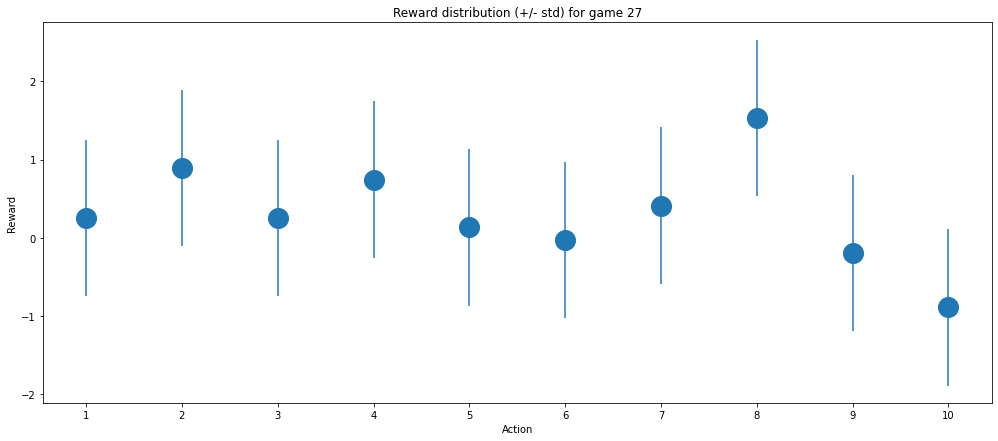

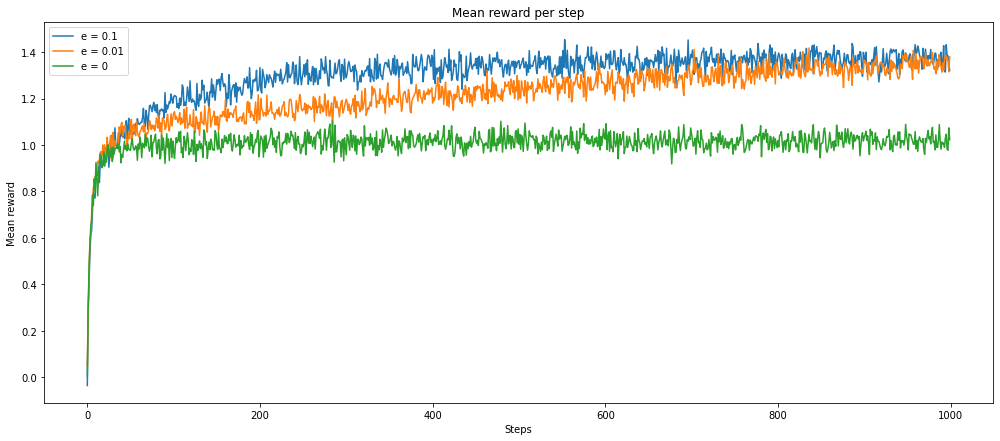

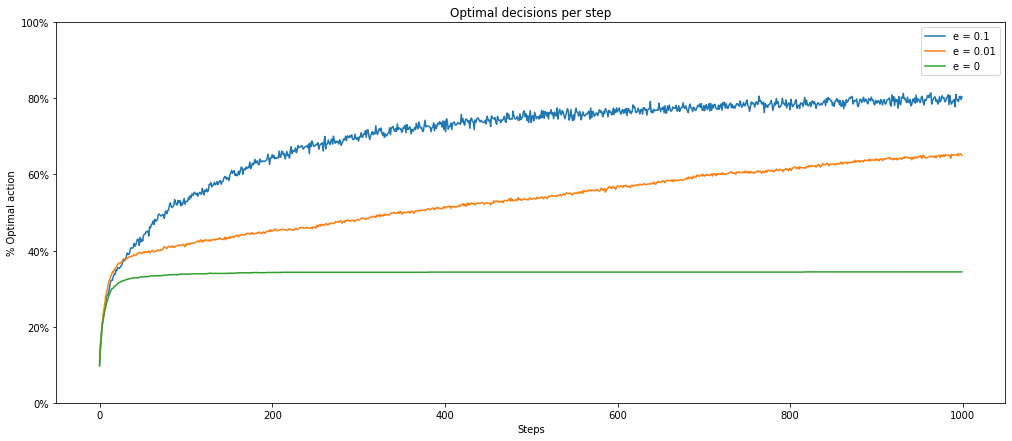

In [10]:
# Figure 2.2

K = 10
N = 2000
tmax = 1000
greedy = simulate_kbandits(K, N, tmax, eps = 0, name = 'e = 0')
eps_greedy_01 = simulate_kbandits(K, N, tmax, eps = 0.1, name = 'e = 0.1')
eps_greedy_001 = simulate_kbandits(K, N, tmax, eps = 0.01, name = 'e = 0.01')

plot_true_action_values(greedy, 27)
plot_mean_rewards(eps_greedy_01, eps_greedy_001, greedy)
plot_optimal_actions(eps_greedy_01, eps_greedy_001, greedy)

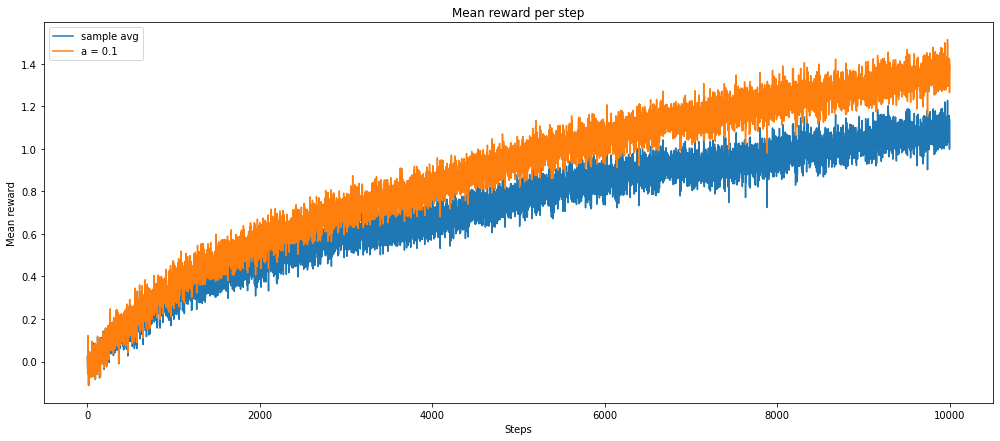

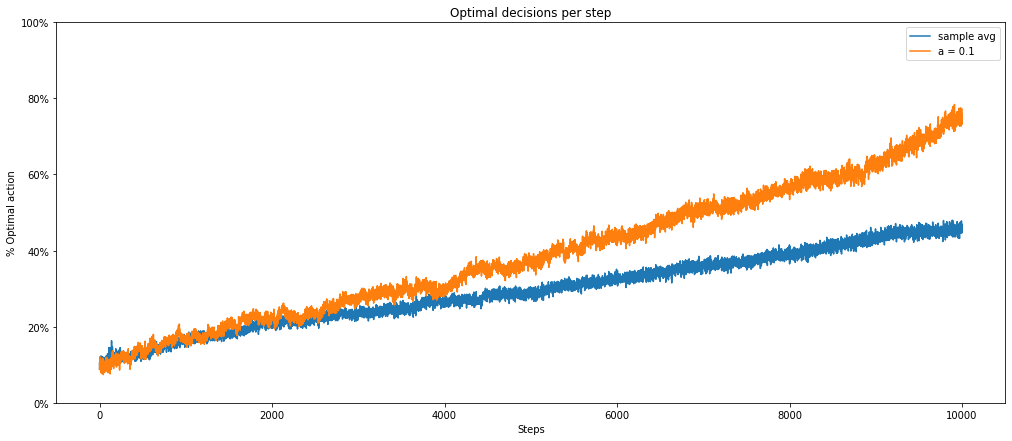

In [11]:
# Exercise 2.5

K = 10
N = 1000
tmax = 10000
sample_avg = simulate_kbandits(K, N, tmax, eps = 0.1, actval_type = 'randomwalk', name = 'sample avg')
const_size = simulate_kbandits(K, N, tmax, eps = 0.1, actval_type = 'randomwalk', stepsize = 0.1, name = 'a = 0.1')

plot_mean_rewards(sample_avg, const_size)
plot_optimal_actions(sample_avg, const_size)

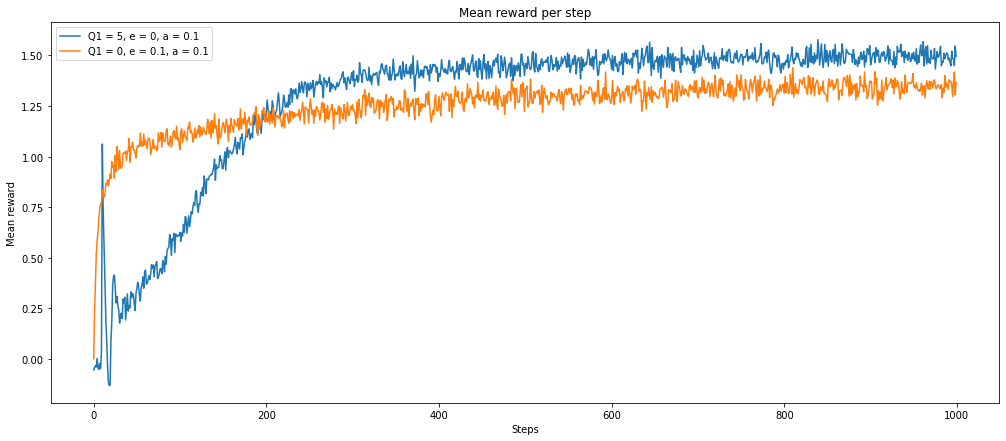

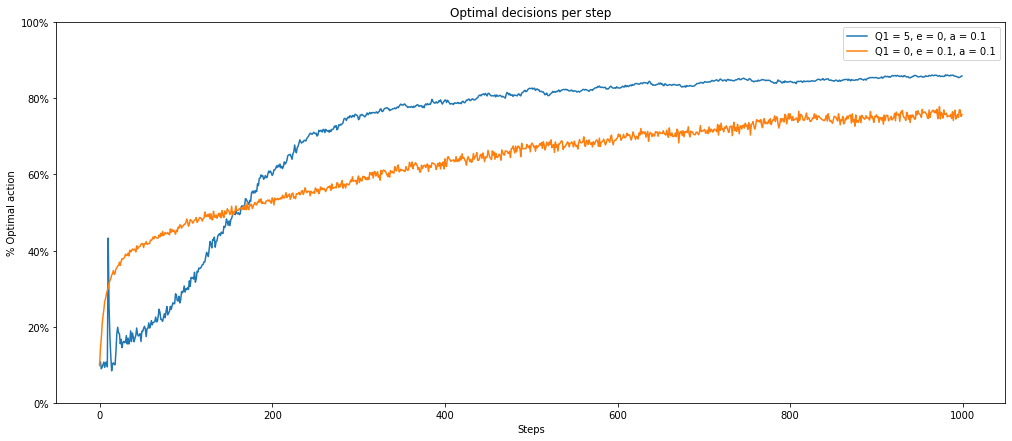

In [12]:
# Figure 2.3

K = 10
N = 2000
tmax = 1000
greed_no_zero_init = simulate_kbandits(K, N, tmax, eps = 0, stepsize = 0.1, actval_init = np.ones(K) * 5.0, name = 'Q1 = 5, e = 0, a = 0.1')
greed_zero_init    = simulate_kbandits(K, N, tmax, eps = 0.1, stepsize = 0.1, actval_init = np.zeros(K), name = 'Q1 = 0, e = 0.1, a = 0.1')

plot_mean_rewards(greed_no_zero_init, greed_zero_init)
plot_optimal_actions(greed_no_zero_init, greed_zero_init)